This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Reloading
from importlib import reload

# Local imports
import sys
sys.path.append('../../../')
import imagestuff as ims
import retrievestuff as rs
import f90nml
import gradstuff as gds
import statstuff as sts

CUDA not available.


In [2]:
%matplotlib notebook

In [3]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments2'
imageroot = 'case3.1'
Calibrationfile = 'Calibration.nml'

/Users/nesh/Documents/Repositories/ice2021/crystals/2023-06-21/case3.1 (calibration2)
2023-06-21/case3.1 (calibration2)


In [4]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments2_retrieved.npz
Segments2_roughness.jpg
Segments2_roughness.txt


In [5]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'_retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'_retrieved'

In [6]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("Filename, dx and dy", Filename, dx, dy)

SEMimages/case3.1-A.bmp
SEMimages/case3.1-B.bmp
SEMimages/case3.1-C.bmp
SEMimages/case3.1-D.bmp
Filename, dx and dy SEMimages/case3.1-D.bmp 1.2402339999999998 1.2402339999999998


In [7]:
# Extract the desired segments
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

Benchmark score for random signals = 7.334476976139673
Correlation of detectors A-D for each segment
for segment  0
nx= 41
ny= 41
0 1 16.60377715977869
0 2 -2.9595421128785357
0 3 41.773434027804505
1 2 -0.2469553180629015
1 3 3.893935906941083
2 3 -0.7271664013840562
Correlation score = 45.22407092154146



<IPython.core.display.Javascript object>


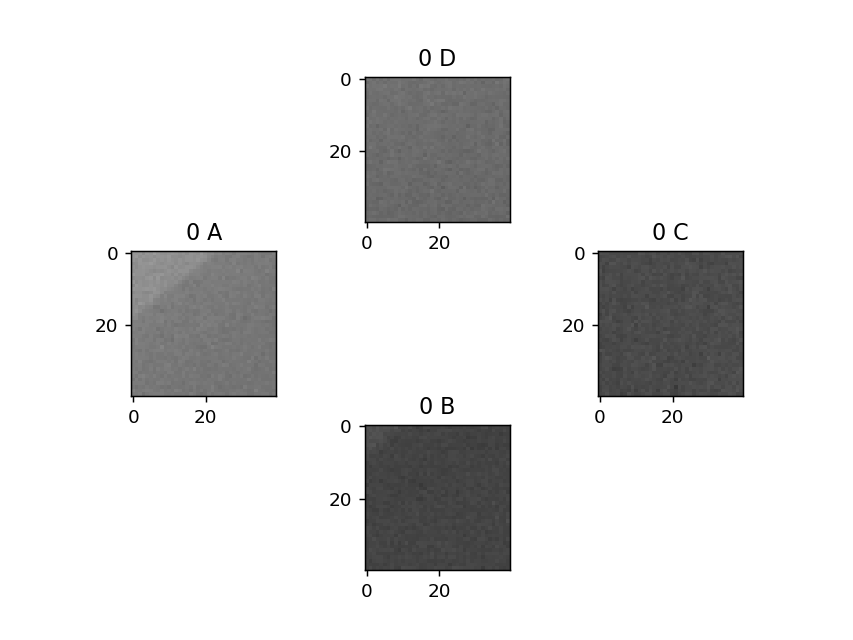

for segment  1
nx= 41
ny= 41
0 1 2.1999440234568253
0 2 -9.89104411707617
0 3 -3.330634119904172
1 2 -35.982516329858996
1 3 -43.1750610081121
2 3 31.724630030378222
Correlation score = 65.4144109208369



<IPython.core.display.Javascript object>


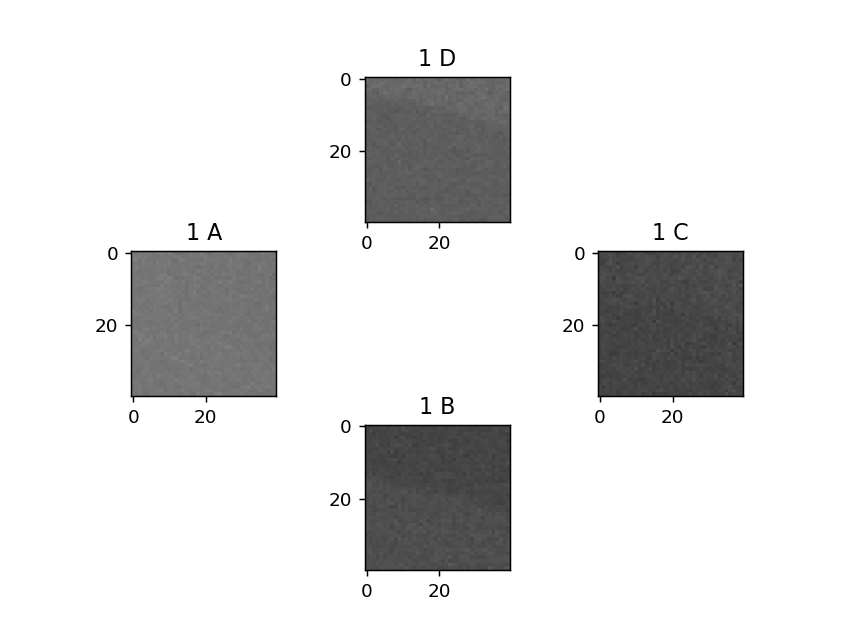

for segment  2
nx= 41
ny= 41
0 1 -2.183627565077485
0 2 2.4798485557657735
0 3 3.761762021578107
1 2 2.128932783883404
1 3 -2.912602157027174
2 3 -0.05729698848704856
Correlation score = 6.171516894393938



<IPython.core.display.Javascript object>


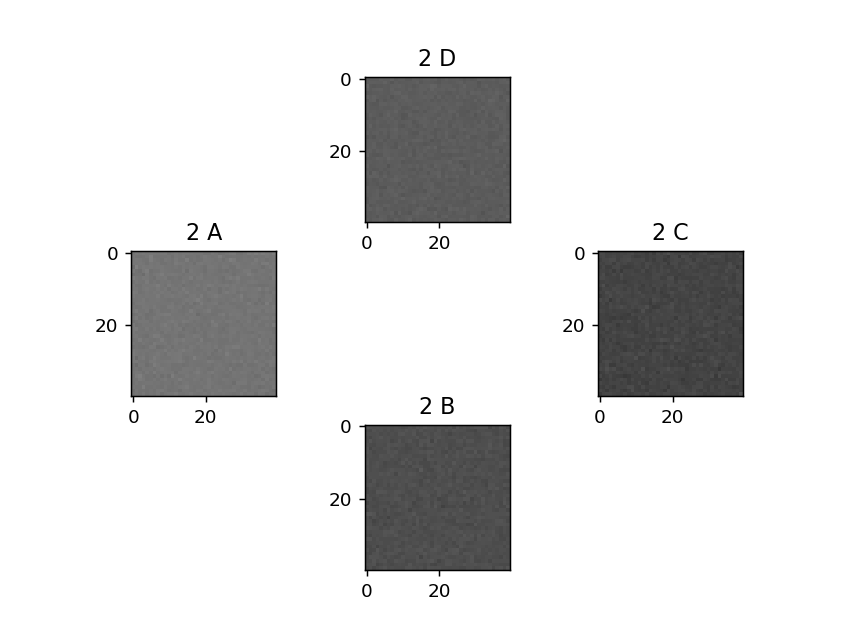

for segment  3
nx= 41
ny= 41
0 1 -4.096948789800395
0 2 -1.8203294804722052
0 3 1.099176762650147
1 2 0.3573283666603194
1 3 -2.4827126536984503
2 3 0.631164886736364
Correlation score = 5.291190145513261



<IPython.core.display.Javascript object>


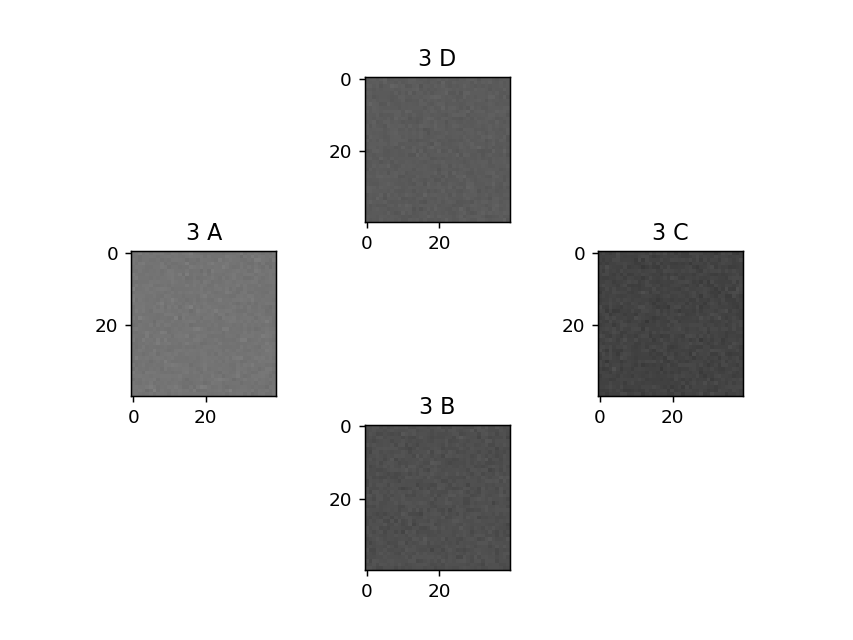

for segment  4
nx= 41
ny= 41
0 1 -3.6996051157376115
0 2 4.9481642898874565
0 3 14.219407878552323
1 2 31.477570094318384
1 3 13.38912684675674
2 3 36.54381494091706
Correlation score = 52.40152207203535



<IPython.core.display.Javascript object>


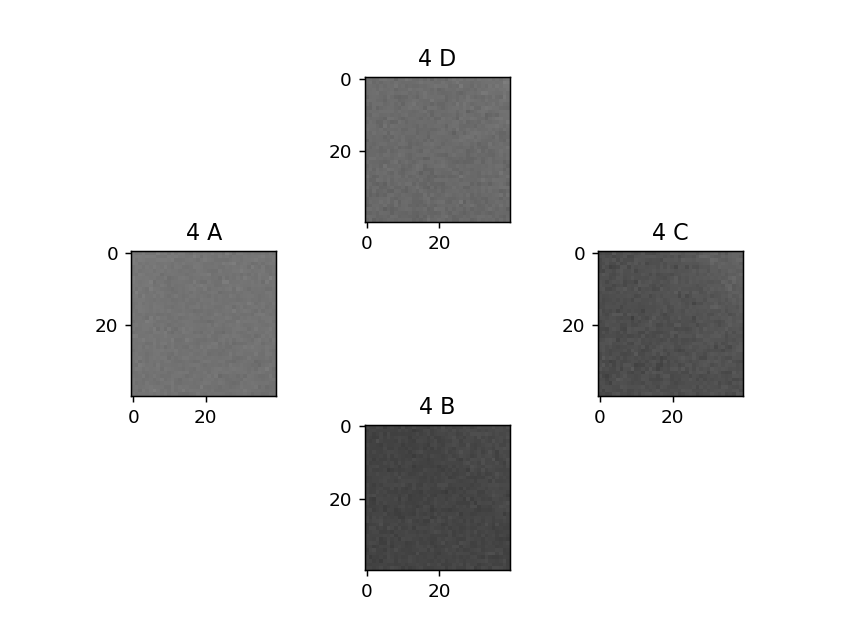

for segment  5
nx= 41
ny= 41
0 1 7.4748990941449875
0 2 -10.283552997320218
0 3 -1.8081959913766217
1 2 -29.72783906455711
1 3 -34.2003910419877
2 3 33.51665228164068
Correlation score = 57.807199331061376



<IPython.core.display.Javascript object>


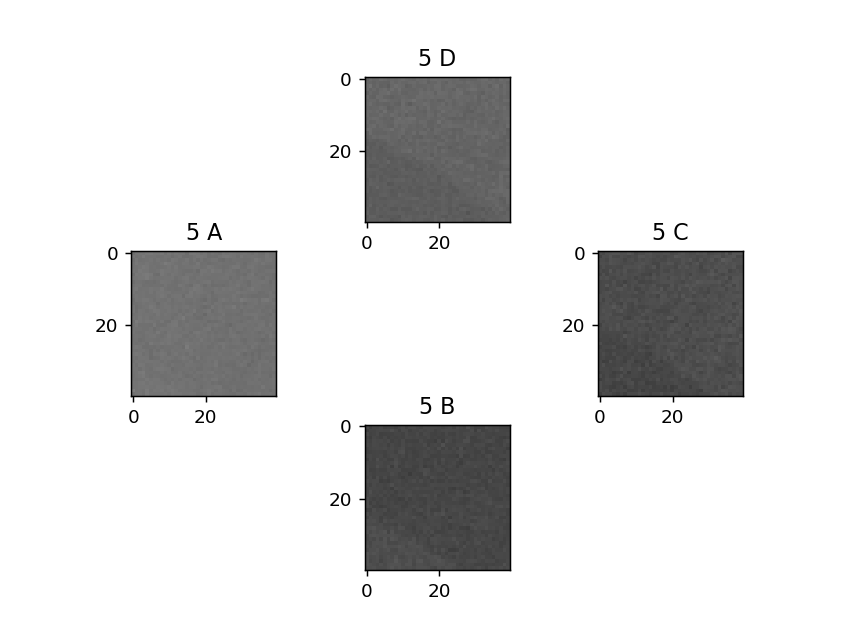

for segment  6
nx= 41
ny= 41
0 1 8.549999239109004
0 2 -11.3812744571138
0 3 -3.0728287678656176
1 2 -7.275197874244784
1 3 -3.992367177544117
2 3 8.353304191371471
Correlation score = 18.72760963382326



<IPython.core.display.Javascript object>


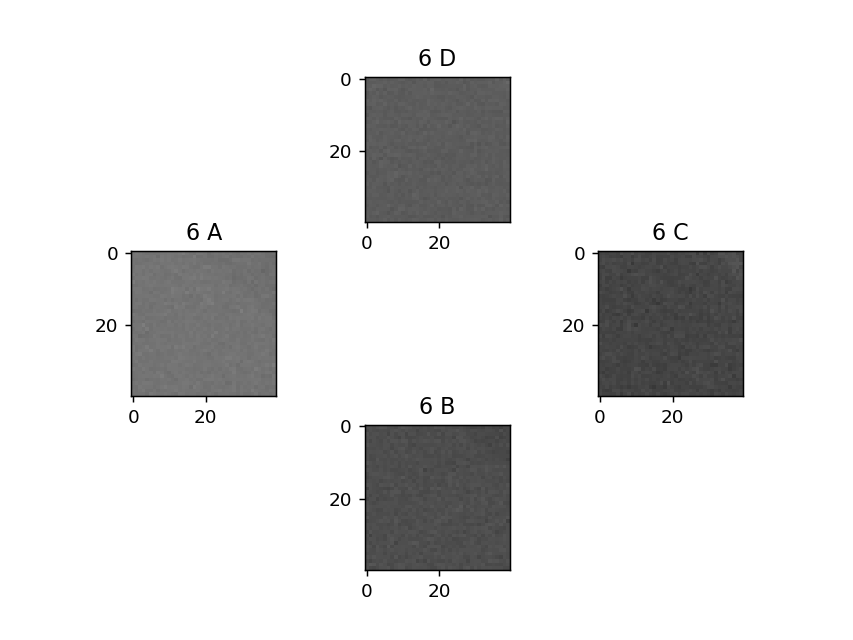

for segment  7
nx= 41
ny= 41
0 1 5.085181144263847
0 2 -3.1151888778191967
0 3 0.4237056611560657
1 2 0.8908524433794085
1 3 -7.231844814367543
2 3 4.467824386046521
Correlation score = 10.430611091459715



<IPython.core.display.Javascript object>


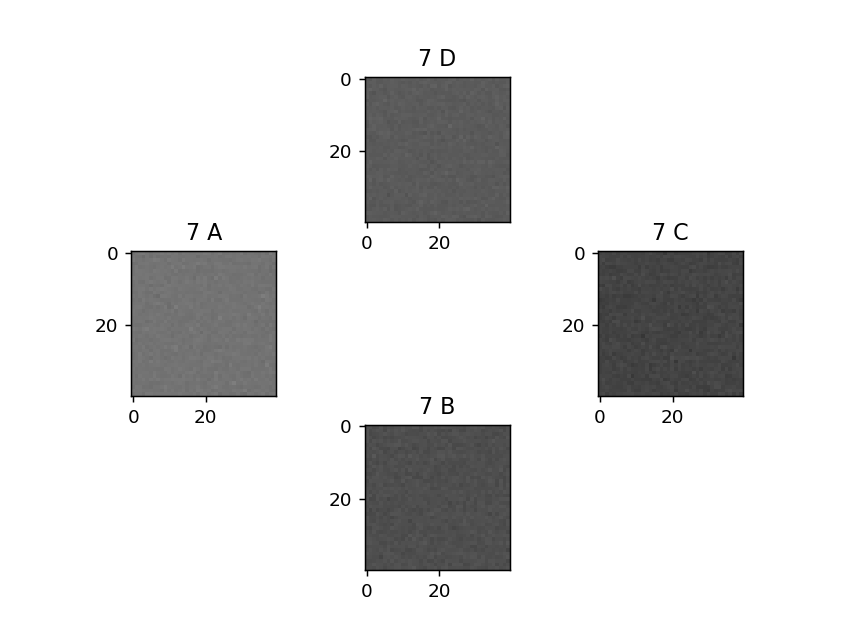

for segment  8
nx= 41
ny= 41
0 1 8.773516017517732
0 2 19.684037850467522
0 3 24.329126689200645
1 2 25.974783117068945
1 3 20.642116047487395
2 3 51.15373549848009
Correlation score = 69.09293236802606



<IPython.core.display.Javascript object>


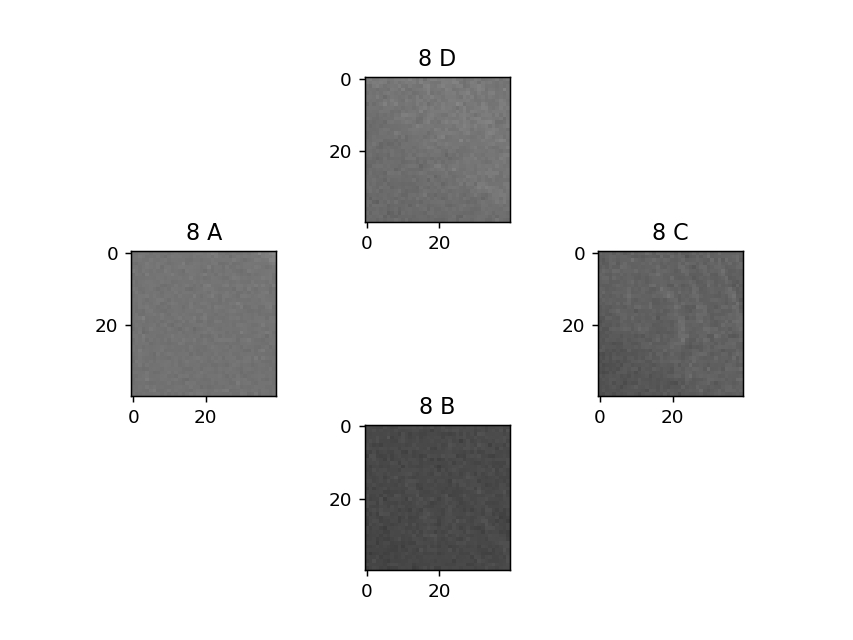

for segment  9
nx= 41
ny= 41
0 1 -4.978087270292525
0 2 18.4755302733728
0 3 21.315820974497996
1 2 5.184551427889064
1 3 -9.717530098377834
2 3 18.679165042261236
Correlation score = 35.92648002472761



<IPython.core.display.Javascript object>


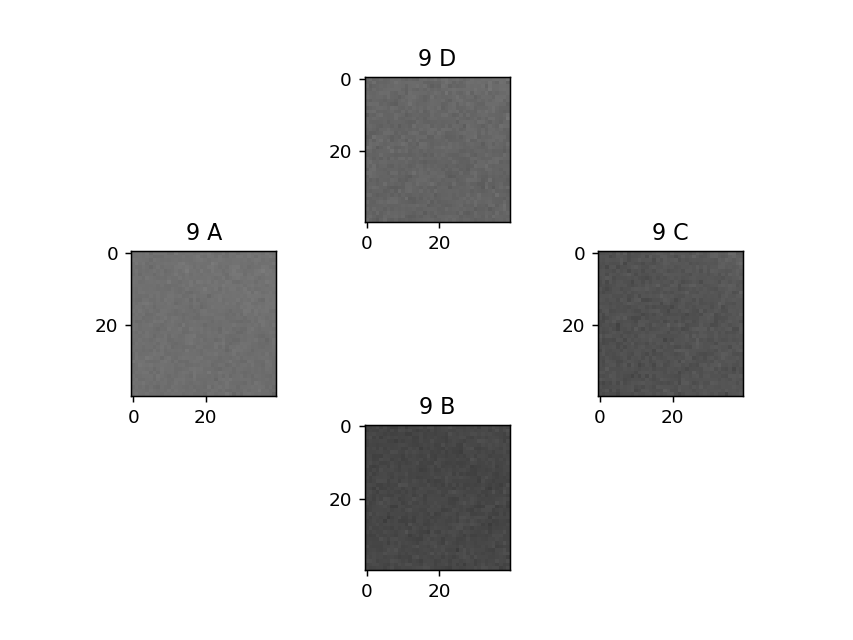

for segment  10
nx= 41
ny= 41
0 1 18.447244382950192
0 2 -32.41469378912139
0 3 -19.87697445103322
1 2 -34.02695200113205
1 3 -26.55409942329473
2 3 42.18588091330221
Correlation score = 73.67977686716148



<IPython.core.display.Javascript object>


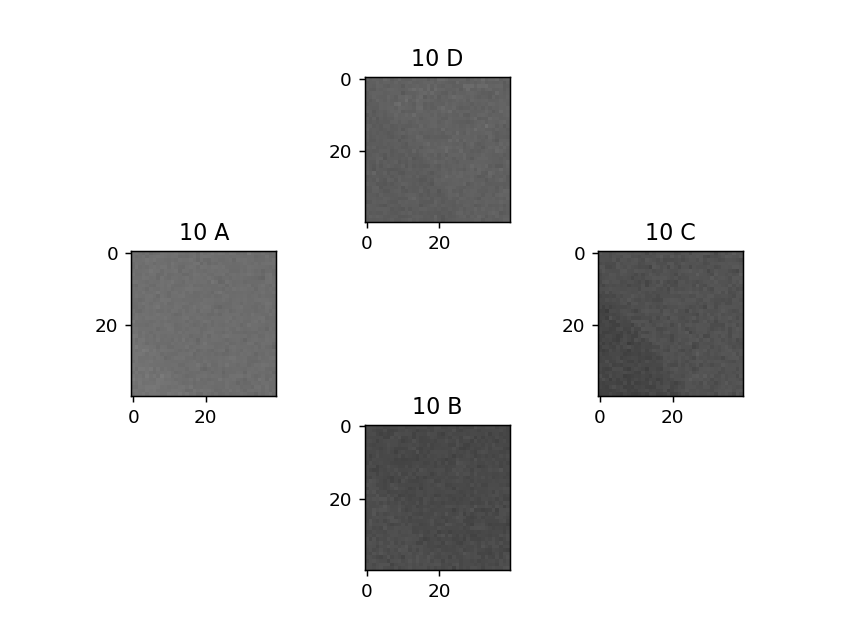

for segment  11
nx= 41
ny= 41
0 1 17.090673769594936
0 2 -45.38731519766131
0 3 -20.02012589887365
1 2 -23.57487113102374
1 3 -16.29625340384382
2 3 28.674049866244083
Correlation score = 66.30572004990105



<IPython.core.display.Javascript object>


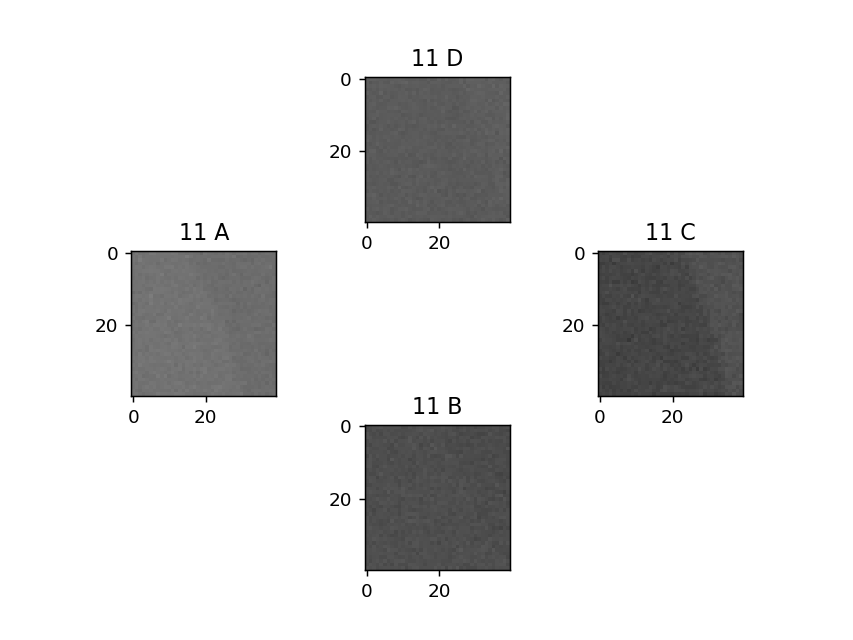

for segment  12
nx= 41
ny= 41
0 1 21.99086962858971
0 2 33.95209164272913
0 3 6.942176831822179
1 2 14.316331418977008
1 3 -7.485512292848341
2 3 8.3451105904727
Correlation score = 44.8906204396173



<IPython.core.display.Javascript object>


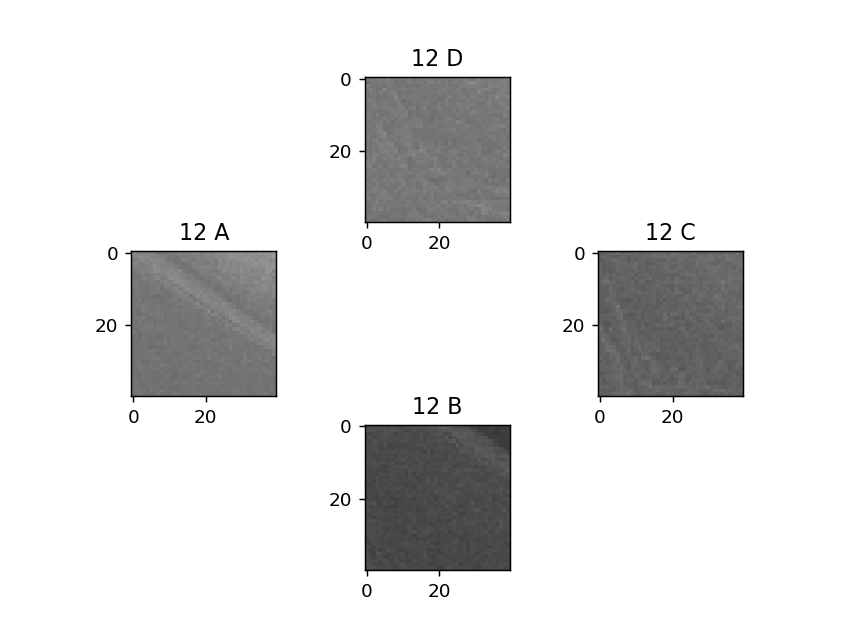

for segment  13
nx= 41
ny= 41
0 1 0.040806687522460194
0 2 19.886144299587155
0 3 17.965772961711444
1 2 17.407020642567403
1 3 10.546588947213268
2 3 67.8189805184266
Correlation score = 75.70917000623166



<IPython.core.display.Javascript object>


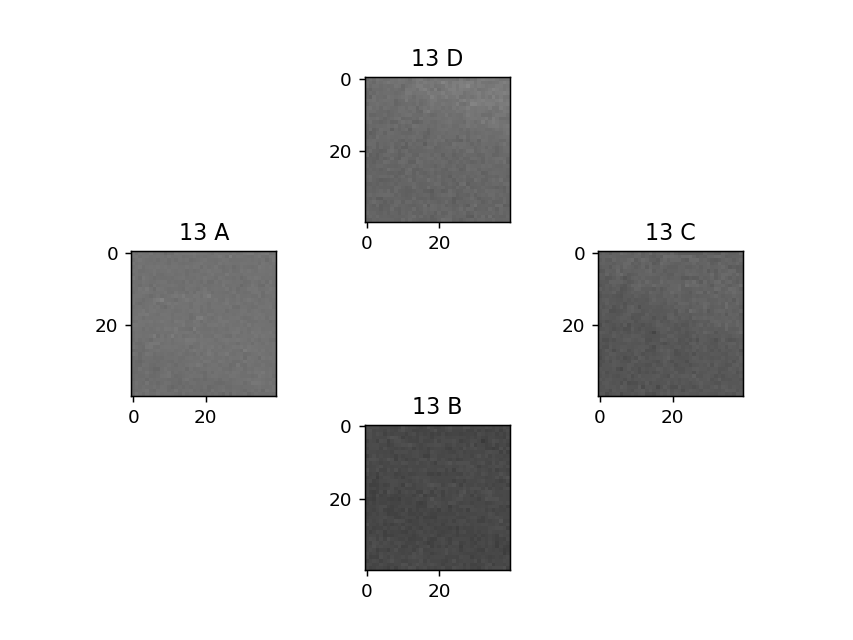

for segment  14
nx= 41
ny= 41
0 1 -9.018093003522932
0 2 -1.7898333782695408
0 3 0.7830770537263485
1 2 2.388323954202577
1 3 -11.162493713802576
2 3 5.253391689083978
Correlation score = 15.589938937470734



<IPython.core.display.Javascript object>


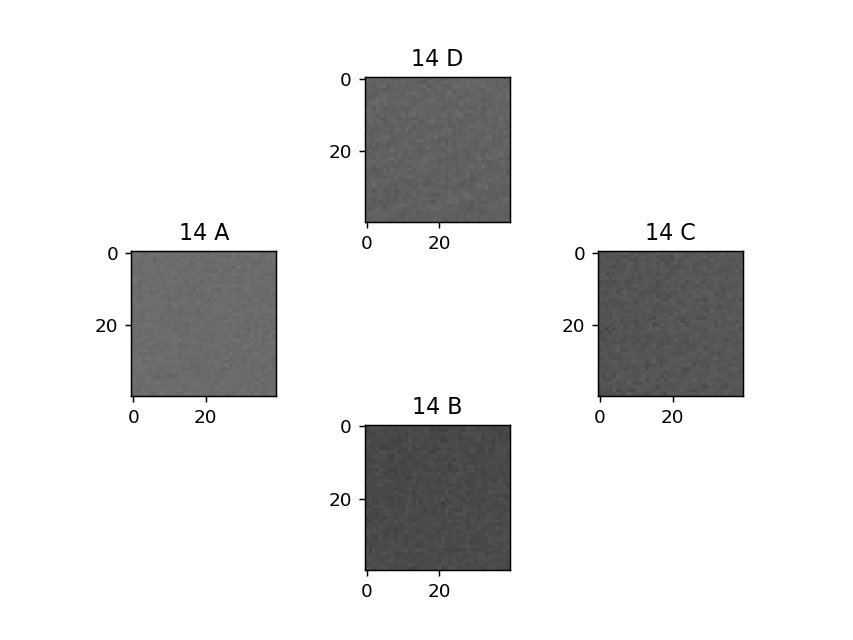

for segment  15
nx= 41
ny= 41
0 1 -1.5194413266195976
0 2 -8.486540256061117
0 3 1.921946527482656
1 2 1.016373992943981
1 3 -10.34893347644195
2 3 -0.5638591716766895
Correlation score = 13.655596774807236



<IPython.core.display.Javascript object>


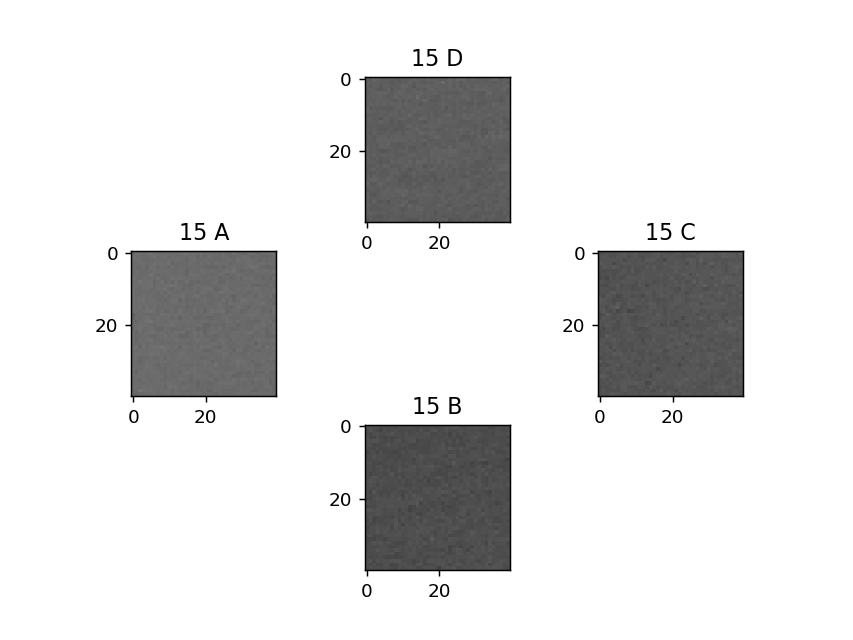

<IPython.core.display.Javascript object>


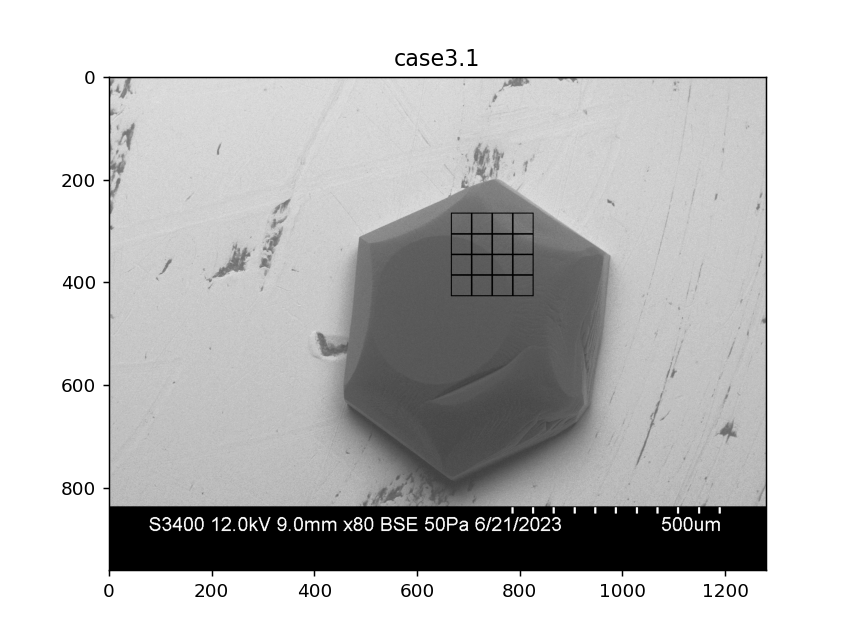

In [8]:
# Display
im = PIL.Image.open(Filename)

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments to the image
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),5)

# What's the random expectation of information content
print('Benchmark score for random signals =', sts.randomcorrelation(nacross,ndown)*100*3)
    
# Loop to evaluate the information content in each segment
print('Correlation of detectors A-D for each segment')
for isegment in range(nsegments):
    
    print('for segment ', isegment)
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1; print('nx=',nx)
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1; print('ny=',ny)
    cAseg = cA[ny1:ny2,nx1:nx2]; #cAsegmean = np.mean(cAseg); print('<cA> =',cAsegmean)
    cBseg = cB[ny1:ny2,nx1:nx2]; #cBsegmean = np.mean(cBseg); print('<cB> =',cBsegmean)
    cCseg = cC[ny1:ny2,nx1:nx2]; #cCsegmean = np.mean(cCseg); print('<cC> =',cCsegmean)
    cDseg = cD[ny1:ny2,nx1:nx2]; #cDsegmean = np.mean(cDseg); print('<cD> =',cDsegmean)
    cseg = [cAseg,cBseg,cCseg,cDseg]
    infoscore = sts.getinfoscore(cseg)
    print('Correlation score =', infoscore)
    print('')

    # Show what the detectors see
    plt.figure()
    plt.subplot(334); plt.imshow(np.asarray(cAseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' A')
    plt.subplot(338); plt.imshow(np.asarray(cBseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' B')
    plt.subplot(336); plt.imshow(np.asarray(cCseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' C')
    plt.subplot(332); plt.imshow(np.asarray(cDseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' D')

# Show it
plt.figure()
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = 0, vmax = 255)
plt.title(imageroot)

# Save a copy
im.save(SEMSegmentjpgfile)

In [9]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

Calibration.nml


In [10]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [11]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [12]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
rs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [13]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [14]:
# Generic retrieval parameters
maxiter = 5
tolerance = 10

In [15]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
#noiseamp = 5.0
noiseamp = 25.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

Std deviation in input signal is 5.0
Std deviation in a priori is 15.0


In [16]:
# Loop to retrieve each segment
reload(rs)
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    #vartemp_long = np.reshape(vartemp,nzpts+1,0) # This appears to have been deprecated
    vartemp_long = vartemp.flatten(order='C')
    Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    #settemp_long = np.reshape(settemp,nzpts+1,0)
    settemp_long = settemp.flatten(order='C')
    settemp_longminus1 = settemp_long[:-1]
    z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print('')
    print("Segment:", isegment, '(', isegment+1, "of", nsegments, ')')
    print("for", nx1, ny1)
    z_retrieved = rs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = np.zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)


Segment: 0 ( 1 of 16 )
for 665 265
Observed intensities (detector B):
mean, max, min = 53.86125 66.0 46.0
<diff>, std(diff), di2 = 5.598354221785205 13.665781376107175 47110.90107295427
<diff>, std(diff), di2 = 1.9873599055305047 5.63346312584102 1470.0247328031062
<diff>, std(diff), di2 = 1.415946938554673 5.124169100775392 55.03609591293535
<diff>, std(diff), di2 = 1.3672629099613982 5.087409361915609 3.0046066233843547

Segment: 1 ( 2 of 16 )
for 665 305
Observed intensities (detector B):
mean, max, min = 58.039375 70.0 48.0
<diff>, std(diff), di2 = 1.551791721785205 8.402905018014025 16552.733020215648
<diff>, std(diff), di2 = -0.48276272349544497 2.8672043038241903 137.4020074540614
<diff>, std(diff), di2 = -0.5988255862452561 2.7237195923173214 0.8757573976556214
Noverlap = 41

Segment: 2 ( 3 of 16 )
for 665 345
Observed intensities (detector B):
mean, max, min = 61.155 71.0 52.0
<diff>, std(diff), di2 = 0.8530417217852053 6.146749464286323 8184.763522192081
<diff>, std(diff), d

160
160


<IPython.core.display.Javascript object>


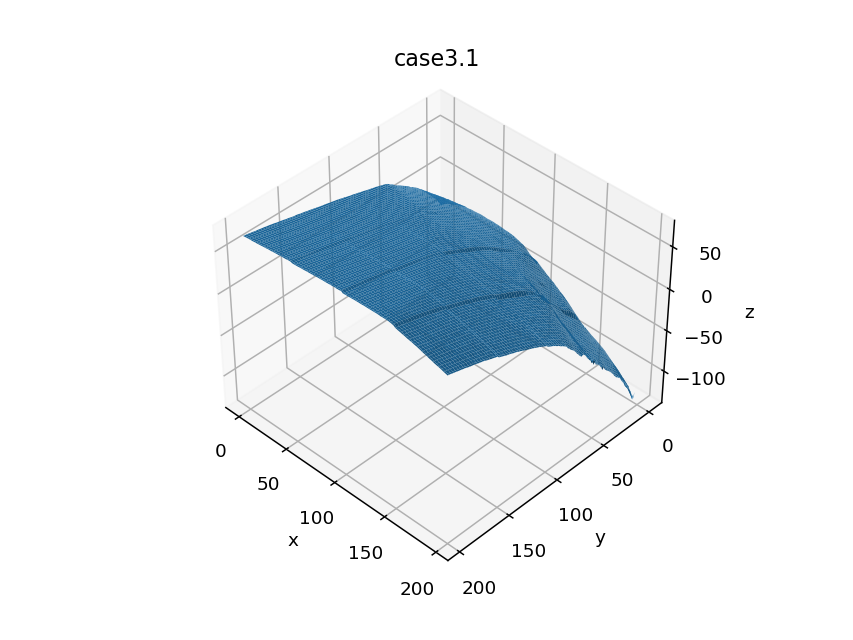

In [17]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=2,cstride=2)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [18]:
# Save this data

#save an image
fig.savefig(Retrievedjpgfile)


print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving Segments2_retrieved
